In [37]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification

# Set seed untuk reproducibility
np.random.seed(42)

# Buat dataset dasar (1.000 data)
n_samples = 1000
X, y = make_classification(
    n_samples=n_samples,
    n_features=12,
    n_informative=8,
    n_redundant=3,
    n_classes=2,
    weights=[0.92, 0.08],
    random_state=42
)

# Buat DataFrame
columns = [f'feature_{i}' for i in range(1, 13)]
df = pd.DataFrame(X, columns=columns)
df['target'] = y

# Tambahkan missing values (35-50% per kolom)
for col in columns:
    missing_ratio = np.random.uniform(0.35, 0.5)  # lebih banyak missing
    mask_random = np.random.choice(
        [True, False],
        size=n_samples,
        p=[missing_ratio * 0.7, 1 - missing_ratio * 0.7]
    )
    mask_systematic = (df[col] > df[col].quantile(0.8))  # nilai tinggi lebih rawan missing
    mask = mask_random | mask_systematic
    df.loc[mask, col] = np.nan

# Tambahkan duplikasi (10%)
n_duplicates = int(n_samples * 0.10)
duplicate_rows = df.sample(n_duplicates, random_state=42)
df = pd.concat([df, duplicate_rows], ignore_index=True)

# Tambahkan outlier (20%) di feature_1 sampai feature_8
for col in ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']:
    outlier_mask = np.random.choice([True, False], size=len(df), p=[0.2, 0.8])
    df.loc[outlier_mask, col] = df.loc[outlier_mask, col] * np.random.uniform(10, 20, size=len(df[outlier_mask]))

# Tambahkan skewness ekstrem di feature_1 sampai feature_4
for col in ['feature_1', 'feature_2', 'feature_3', 'feature_4']:
    df[col] = np.expm1(df[col].clip(lower=0) + np.random.exponential(scale=5, size=len(df)))

# Feature 9-12 menjadi kategorikal
df['feature_9'] = pd.qcut(df['feature_9'].fillna(df['feature_9'].median()), q=4, labels=False, duplicates='drop')
df['feature_10'] = np.random.choice([f'cat10_{i}' for i in range(15)], size=len(df), p=[1/15]*15)
df['feature_11'] = np.random.choice([f'cat11_{i}' for i in range(30)], size=len(df), p=[1/30]*30)
df['feature_12'] = pd.qcut(df['feature_12'].fillna(df['feature_12'].median()), q=3, labels=False, duplicates='drop')

# Tambahkan noise random kasar di feature_5 sampai feature_8
for col in ['feature_5', 'feature_6', 'feature_7', 'feature_8']:
    df[col] += np.random.normal(0, 1, len(df))

# Reset index
df.reset_index(drop=True, inplace=True)

# Simpan dataset
df.to_csv('dummy_dataset_sangat_hancur.csv', index=False)

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (1100, 13)
      feature_1    feature_2     feature_3    feature_4  feature_5  feature_6  \
0  1.150989e+05   254.937046           NaN  1438.293679  -1.978103        NaN   
1  5.235918e+06  1249.286438           NaN    96.842802        NaN        NaN   
2           NaN     0.884229  5.381395e+04   621.323045        NaN        NaN   
3           NaN    81.491716  5.653668e+08          NaN -19.242621  -0.106352   
4           NaN          NaN  1.628525e+07    18.993188        NaN        NaN   

   feature_7  feature_8  feature_9 feature_10 feature_11  feature_12  target  
0        NaN        NaN          1    cat10_2    cat11_0           0       0  
1   0.859545        NaN          0    cat10_9    cat11_8           0       0  
2        NaN   2.010798          1    cat10_1    cat11_5           1       0  
3  -2.620403        NaN          1    cat10_0    cat11_5           1       0  
4  -1.368990 -20.079666          1    cat10_1   cat11_21           0       0  


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Load dataset
df = pd.read_csv('dummy_dataset_sangat_hancur.csv')

Statistik Deskriptif Sebelum Pra-Pemrosesan:
          feature_1     feature_2     feature_3     feature_4   feature_5  \
count  6.060000e+02  6.140000e+02  5.860000e+02  5.960000e+02  649.000000   
mean   3.002263e+11  6.051537e+18  7.147121e+11  6.192315e+14   -8.711418   
std    5.862479e+12  1.498217e+20  1.535006e+13  1.170887e+16   17.400239   
min    8.303560e-03  3.619824e-02  1.674982e-02  3.076901e-02 -114.234858   
25%    5.900339e+00  5.873341e+00  5.359018e+00  5.520142e+00   -5.280524   
50%    8.096345e+01  7.395944e+01  4.557769e+01  6.957583e+01   -2.463345   
75%    5.251184e+03  3.516587e+03  2.698807e+03  3.775805e+03   -0.841763   
max    1.432868e+14  3.712441e+21  3.701335e+14  2.729555e+17    6.271828   

        feature_6   feature_7   feature_8    feature_9   feature_12  \
count  663.000000  607.000000  661.000000  1100.000000  1100.000000   
mean    -1.201223   -2.668607    1.755029     1.269091     0.275455   
std      5.479546    8.881558   15.273364     1.

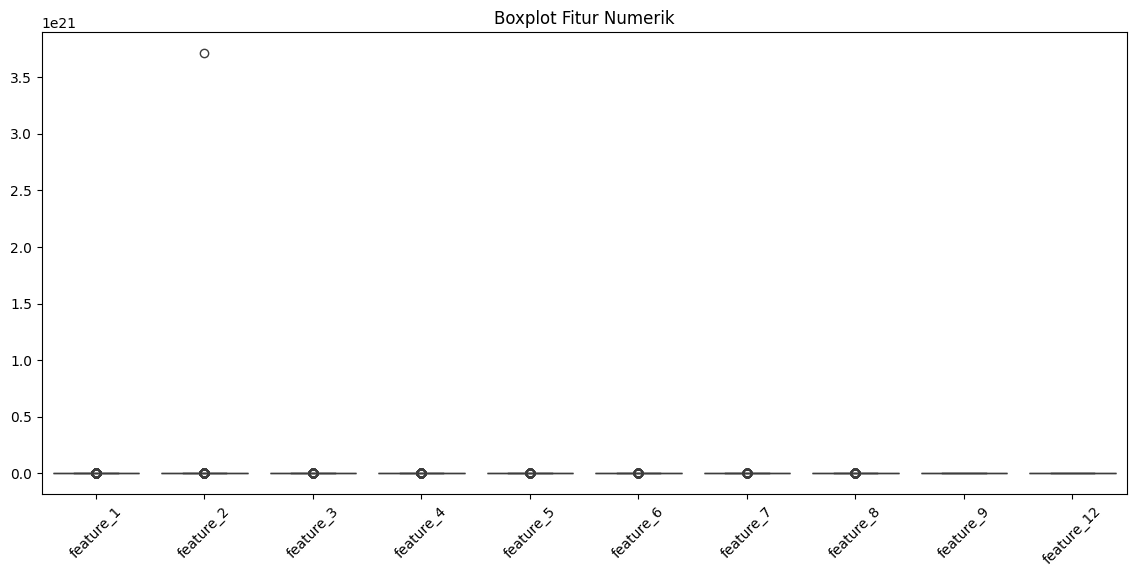

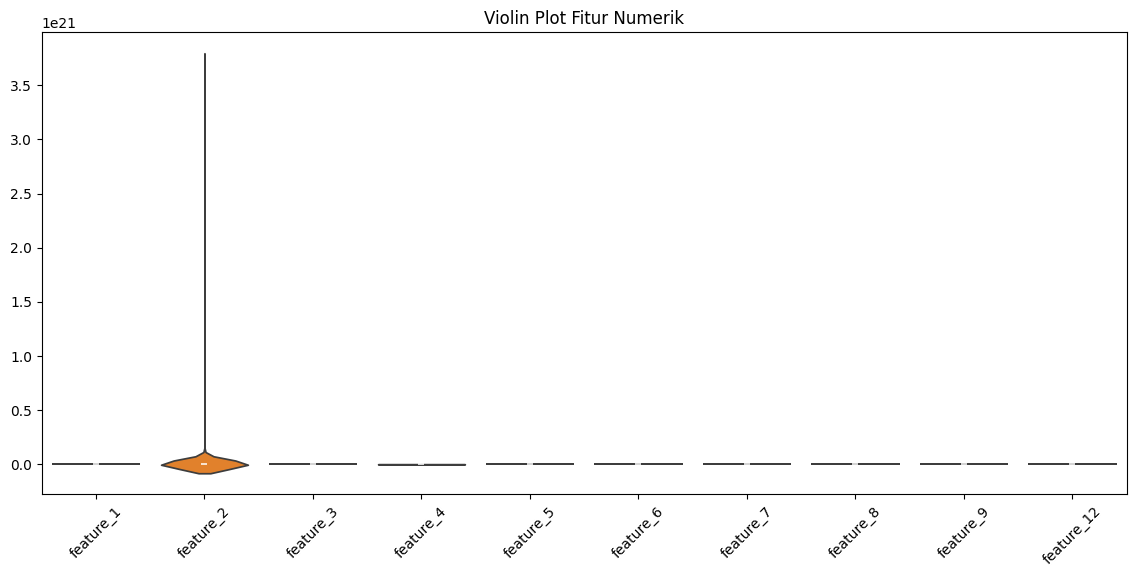

In [39]:
# 3.1 Skala Fitur
print("Statistik Deskriptif Sebelum Pra-Pemrosesan:")
print(df.describe())
plt.figure(figsize=(14, 6))
sns.boxplot(data=df.drop(columns=['target']))
plt.title("Boxplot Fitur Numerik")
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(14, 6))
sns.violinplot(data=df.drop(columns=['target']))
plt.title("Violin Plot Fitur Numerik")
plt.xticks(rotation=45)
plt.show()

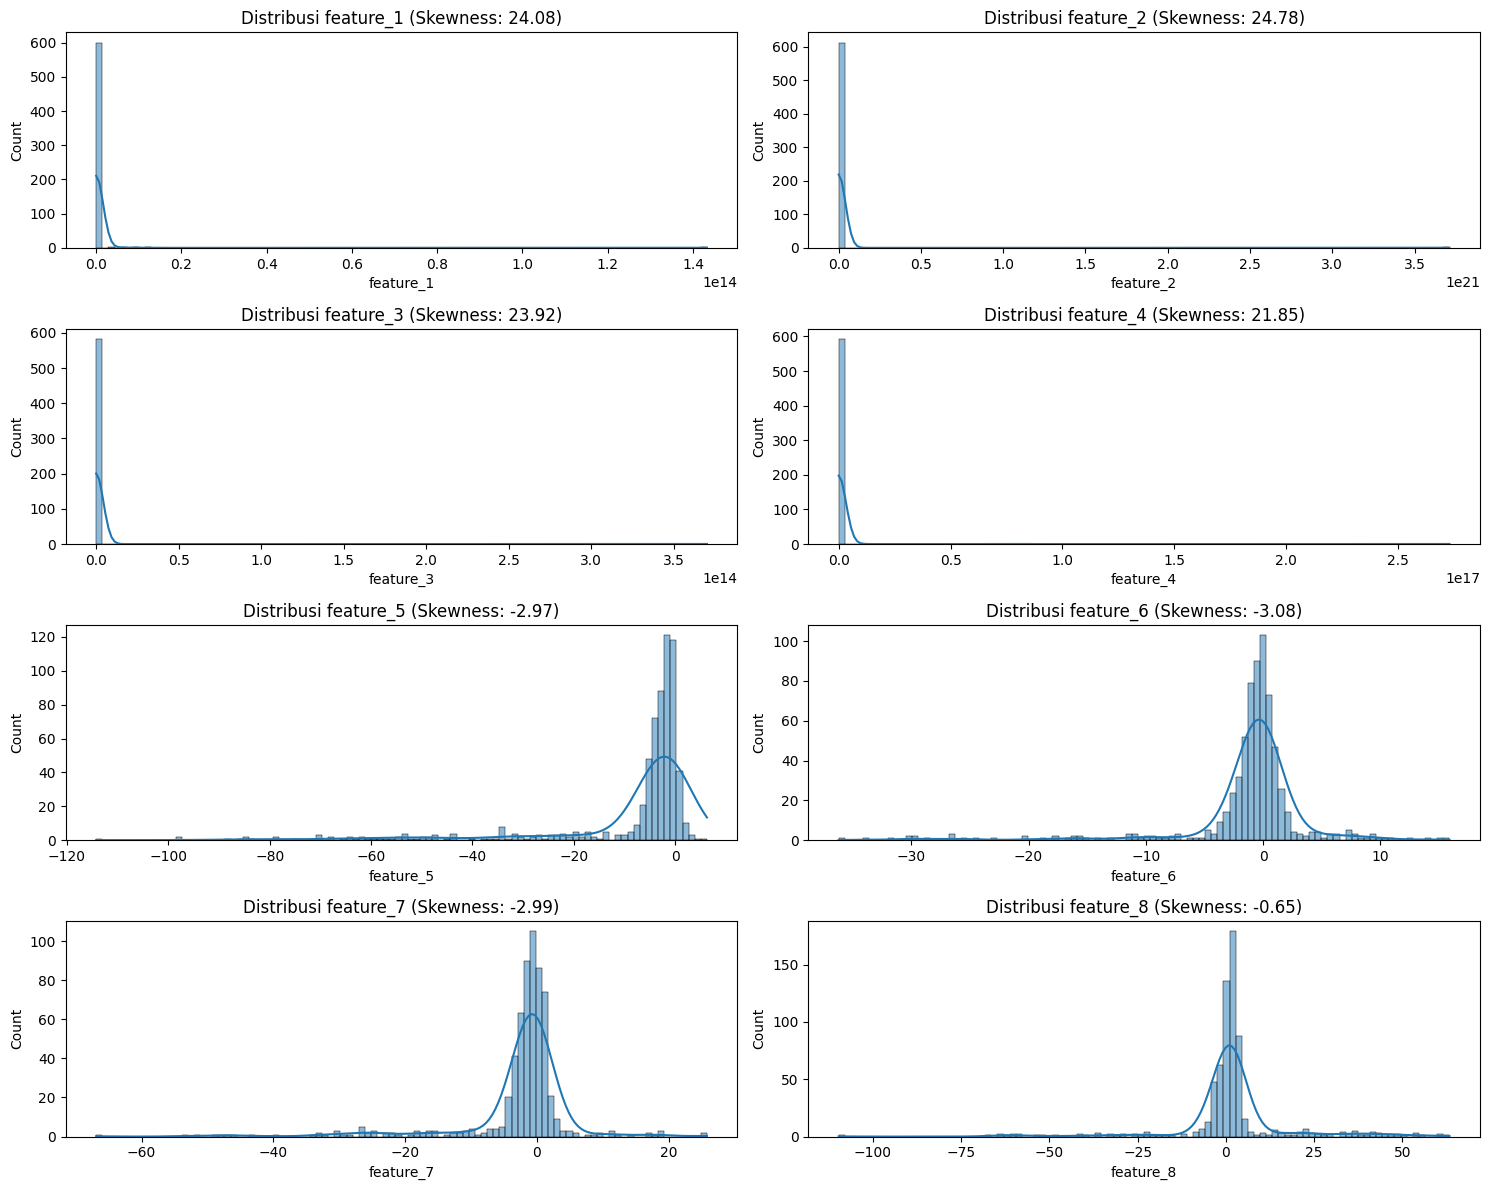

In [40]:
# 3.2 Distribusi dan Skewness
plt.figure(figsize=(15, 12))
for i, col in enumerate(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']):
    plt.subplot(4, 2, i+1)
    # Instead of 'auto', specify a reasonable number of bins
    # or use a different binning strategy like 'fd' or 'doane'
    sns.histplot(df[col].dropna(), kde=True, bins=100)  # Changed to 100 bins
    plt.title(f'Distribusi {col} (Skewness: {df[col].skew():.2f})')
plt.tight_layout()
plt.show()

In [41]:
# 3.3 Outlier (IQR)
def detect_outliers_iqr(data, col):
    Q1, Q3 = data[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower) | (data[col] > upper)][col]
    return len(outliers)

print("Jumlah Outlier per Fitur:")
for col in ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']:
    print(f"{col}: {detect_outliers_iqr(df, col)}")

Jumlah Outlier per Fitur:
feature_1: 134
feature_2: 131
feature_3: 117
feature_4: 124
feature_5: 106
feature_6: 90
feature_7: 82
feature_8: 112


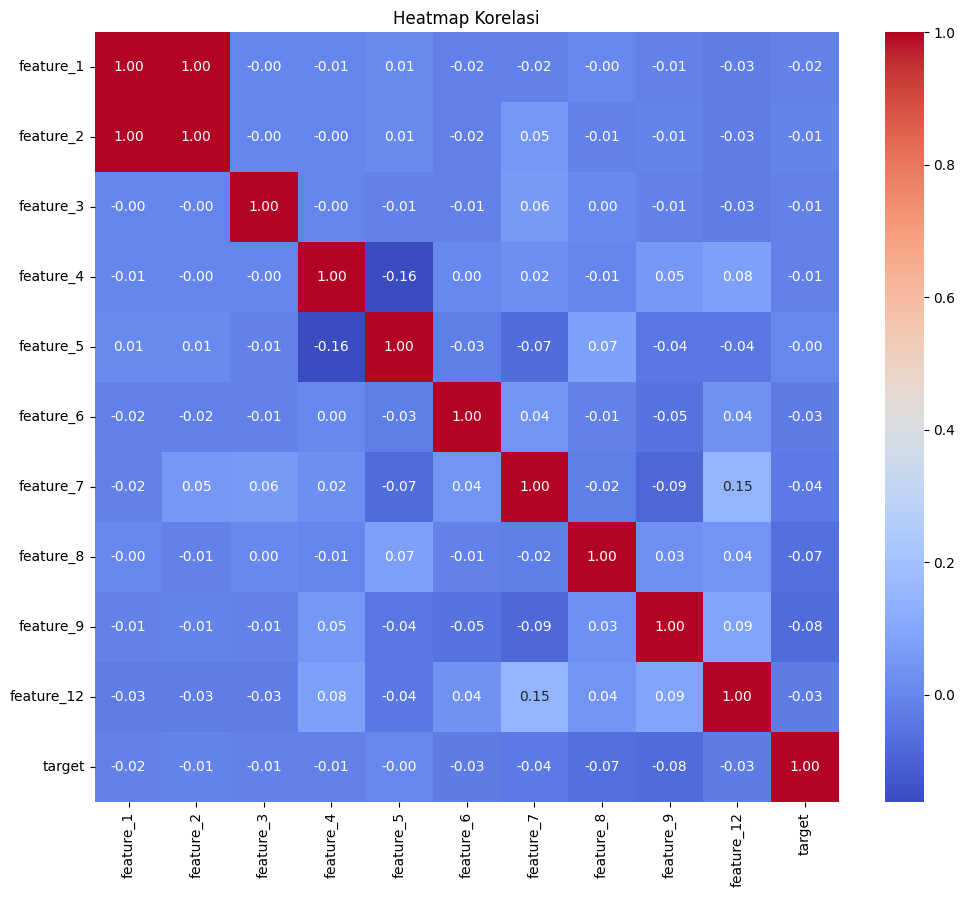

In [42]:
# 3.4 Korelasi Antar Fitur
plt.figure(figsize=(12, 10))
# Select only numeric features for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap Korelasi")
plt.show()

Persentase Missing Values:
feature_1     44.909091
feature_2     44.181818
feature_3     46.727273
feature_4     45.818182
feature_5     41.000000
feature_6     39.727273
feature_7     44.818182
feature_8     39.909091
feature_9      0.000000
feature_10     0.000000
feature_11     0.000000
feature_12     0.000000
target         0.000000
dtype: float64


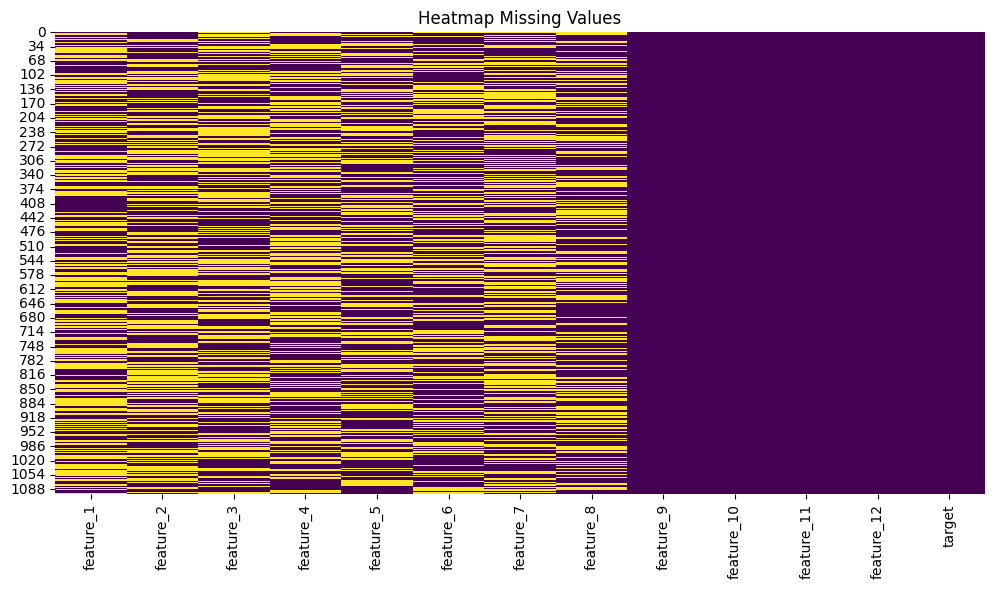

In [43]:
# 3.5 Missing Values
print("Persentase Missing Values:")
print(df.isna().mean() * 100)
plt.figure(figsize=(12, 6))
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title("Heatmap Missing Values")
plt.show()

Proporsi Kelas: target
0    0.916364
1    0.083636
Name: proportion, dtype: float64


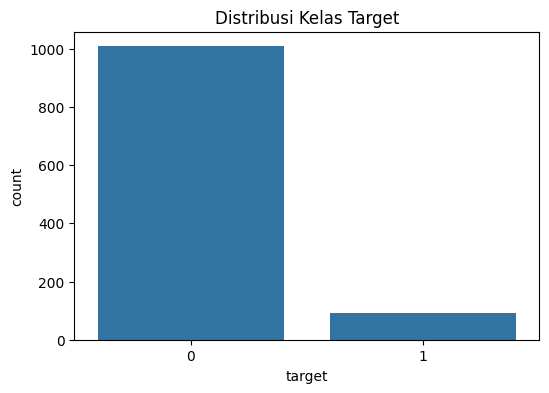

In [44]:
# 3.6 Distribusi Kelas Target
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title("Distribusi Kelas Target")
print("Proporsi Kelas:", df['target'].value_counts(normalize=True))
plt.show()

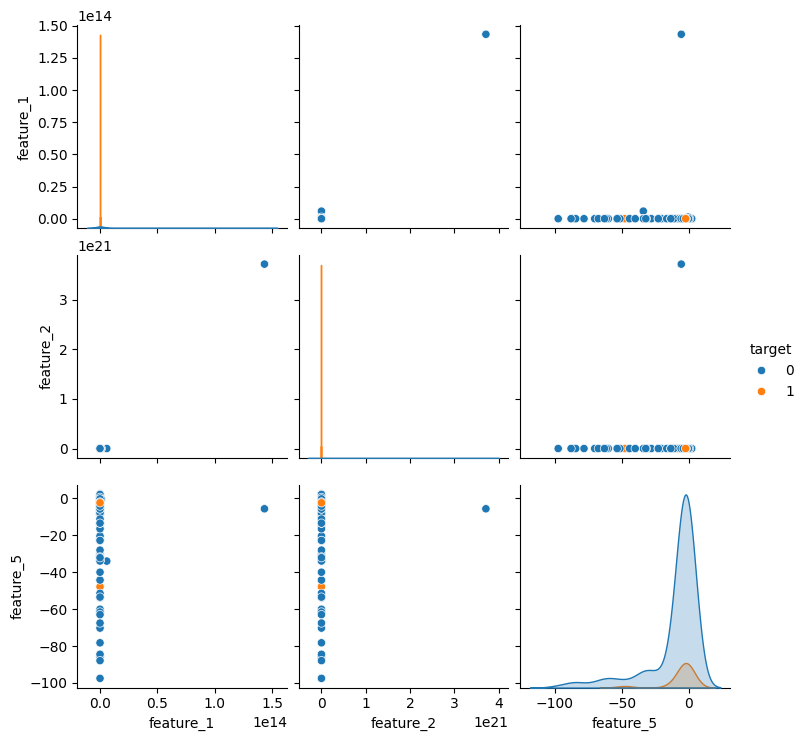

In [45]:
# 3.7 Hubungan Antar Fitur
sns.pairplot(df[['feature_1', 'feature_2', 'feature_5', 'target']].dropna(), hue='target')
plt.show()

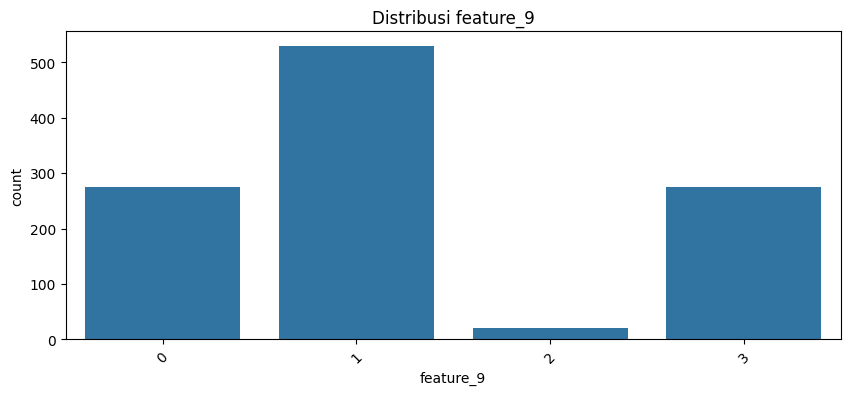

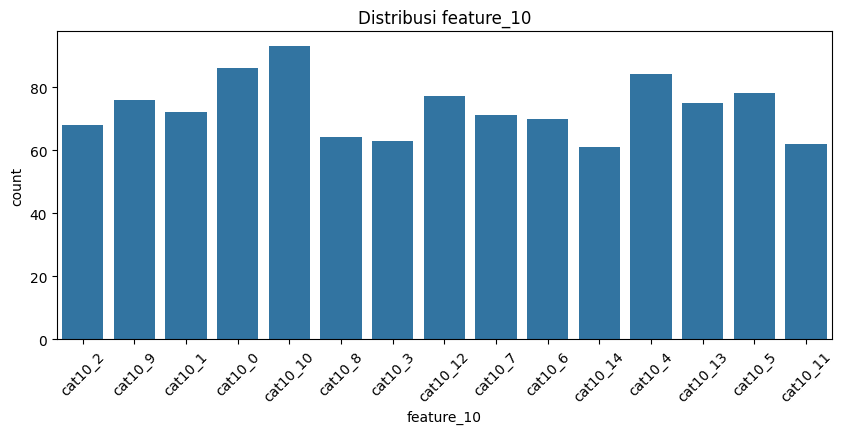

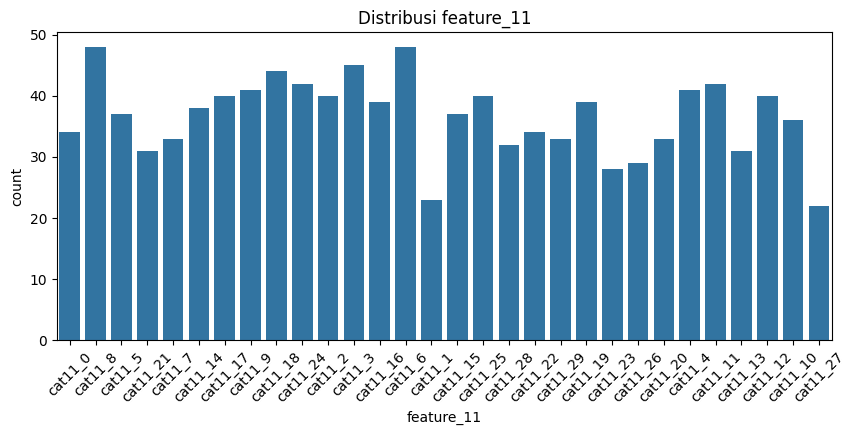

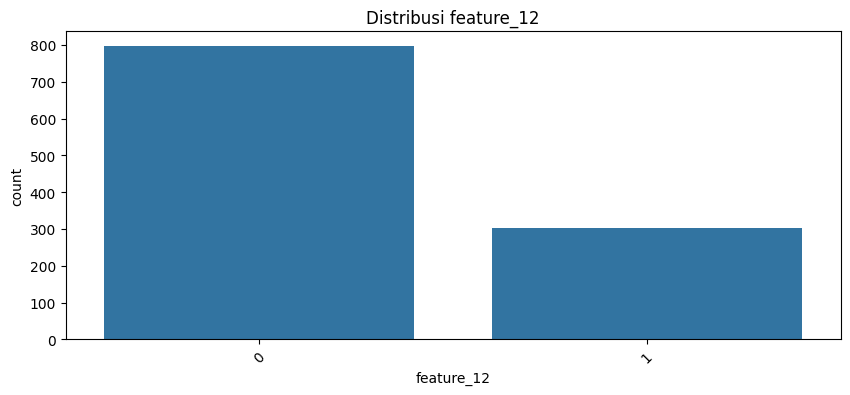

In [46]:
# 3.8 Distribusi Kategorikal
for col in ['feature_9', 'feature_10', 'feature_11', 'feature_12']:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribusi {col}')
    plt.xticks(rotation=45)
    plt.show()

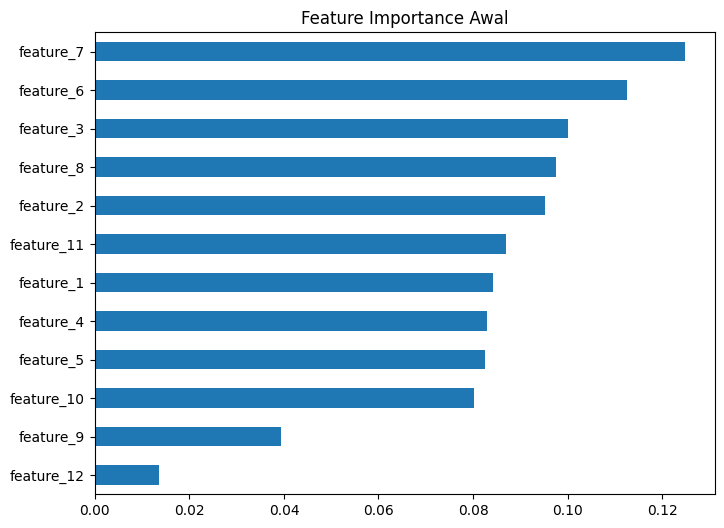

In [47]:
# 3.9 Feature Importance Awal
df_temp = df.copy()
for col in ['feature_9', 'feature_10', 'feature_11', 'feature_12']:
    df_temp[col] = df_temp[col].astype('category').cat.codes
df_temp = df_temp.fillna(df_temp.median())
rf_initial = RandomForestClassifier(n_estimators=50, random_state=42)
rf_initial.fit(df_temp.drop('target', axis=1), df_temp['target'])
importances = pd.Series(rf_initial.feature_importances_, index=df_temp.drop('target', axis=1).columns)
plt.figure(figsize=(8, 6))
importances.sort_values().plot(kind='barh')
plt.title("Feature Importance Awal")
plt.show()

In [48]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE

# Salin dataset
df_processed = df.copy()

# Fungsi untuk menampilkan perbandingan sebelum dan sesudah
def compare_before_after(before, after, metric_name, cols=None):
    if cols is None:
        cols = before.columns
    comparison = pd.DataFrame({
        'Sebelum': before[cols].agg(metric_name),
        'Sesudah': after[cols].agg(metric_name)
    })
    print(f"\nPerbandingan {metric_name}:")
    print(comparison)


Sebelum Penanganan Outlier:
Jumlah outlier (IQR):
feature_1: 134
feature_2: 131
feature_3: 117
feature_4: 124
feature_5: 106
feature_6: 90
feature_7: 82
feature_8: 112


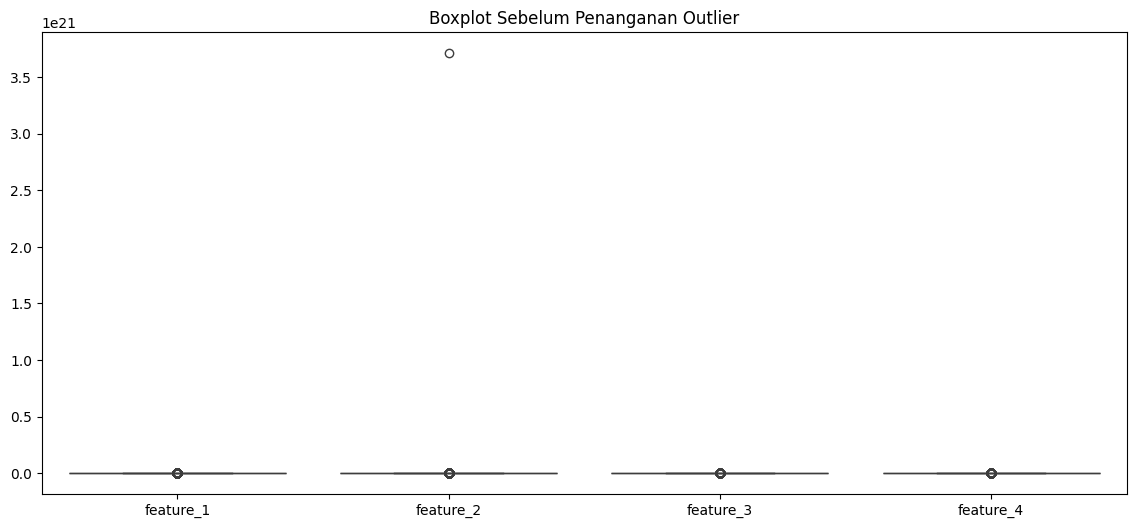


Sesudah Penanganan Outlier:
Jumlah outlier (IQR):
feature_1: 30
feature_2: 31
feature_3: 21
feature_4: 27
feature_5: 76
feature_6: 67
feature_7: 63
feature_8: 90


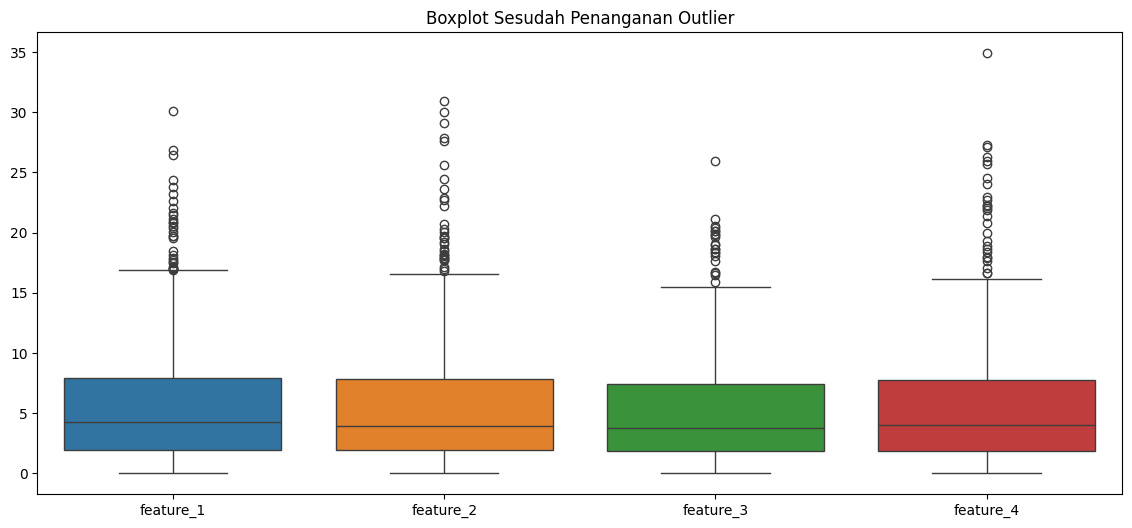

Shape setelah hapus outlier: (990, 13)


In [49]:
# 4.1 Penanganan Outlier (Isolation Forest + Log Transformasi)
# Sebelum
print("\nSebelum Penanganan Outlier:")
print("Jumlah outlier (IQR):")
for col in ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']:
    print(f"{col}: {detect_outliers_iqr(df_processed, col)}")
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_processed[['feature_1', 'feature_2', 'feature_3', 'feature_4']])
plt.title("Boxplot Sebelum Penanganan Outlier")
plt.show()

# Log Transformasi
for col in ['feature_1', 'feature_2', 'feature_3', 'feature_4']:
    df_processed[col] = np.log1p(df_processed[col].clip(lower=0))

# Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
numeric_cols = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']
outlier_mask = iso_forest.fit_predict(df_processed[numeric_cols].fillna(df_processed[numeric_cols].median()))
df_processed = df_processed[outlier_mask == 1]

# Sesudah
print("\nSesudah Penanganan Outlier:")
print("Jumlah outlier (IQR):")
for col in numeric_cols:
    print(f"{col}: {detect_outliers_iqr(df_processed, col)}")
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_processed[['feature_1', 'feature_2', 'feature_3', 'feature_4']])
plt.title("Boxplot Sesudah Penanganan Outlier")
plt.show()
print("Shape setelah hapus outlier:", df_processed.shape)


Sebelum Imputasi Missing Values:
feature_1     46.767677
feature_2     44.949495
feature_3     49.090909
feature_4     46.565657
feature_5     42.020202
feature_6     40.707071
feature_7     45.252525
feature_8     39.595960
feature_9      0.000000
feature_10     0.000000
feature_11     0.000000
feature_12     0.000000
target         0.000000
dtype: float64


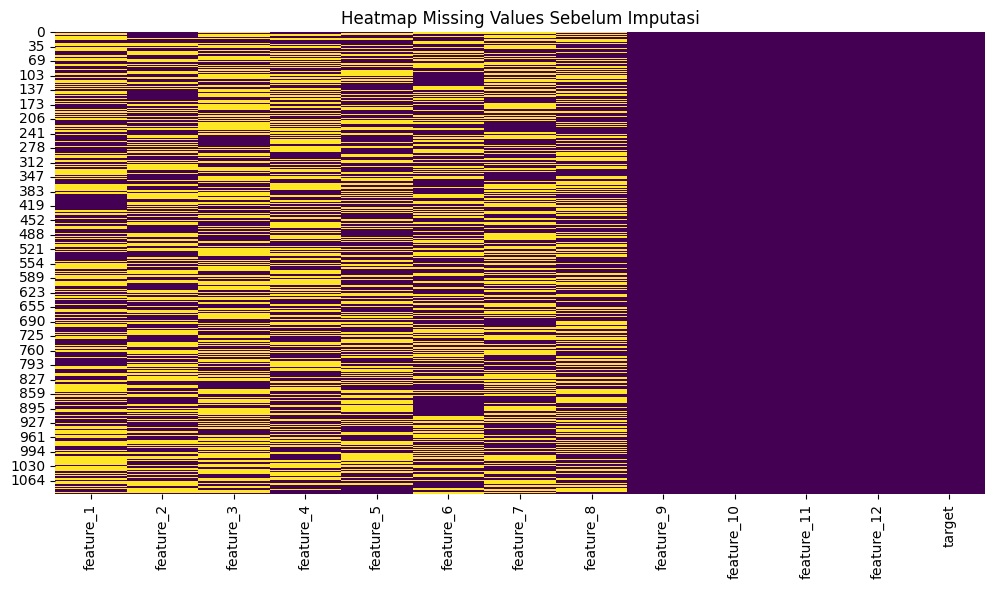

<ipython-input-50-848fdd8220d8>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(df_processed[col].median(), inplace=True)
<ipython-input-50-848fdd8220d8>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl


Sesudah Imputasi Missing Values:
feature_1     0.0
feature_2     0.0
feature_3     0.0
feature_4     0.0
feature_5     0.0
feature_6     0.0
feature_7     0.0
feature_8     0.0
feature_9     0.0
feature_10    0.0
feature_11    0.0
feature_12    0.0
target        0.0
dtype: float64


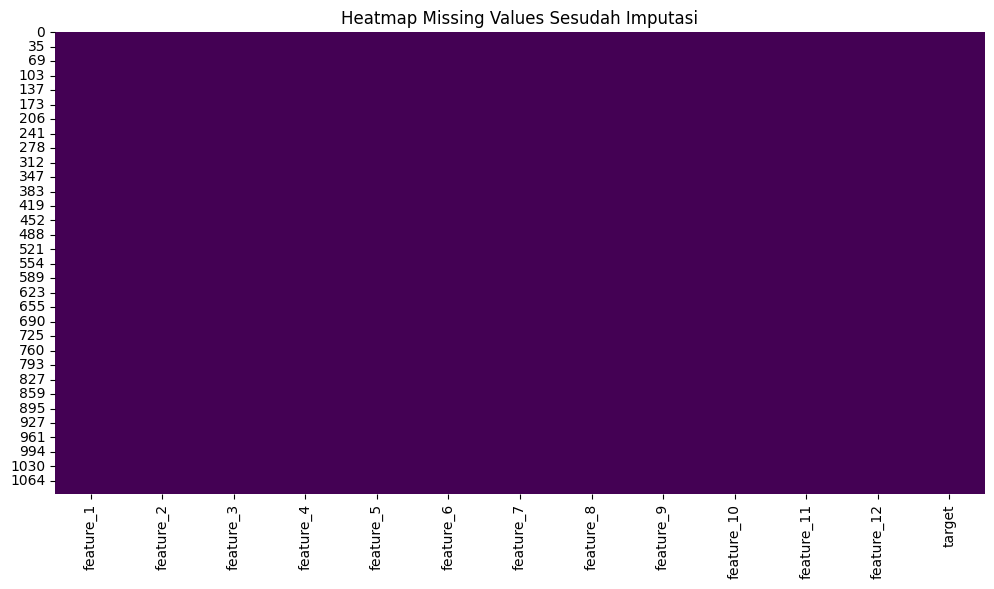

In [50]:
# 4.3 Penanganan Missing Values (Median Imputation)
# Sebelum
print("\nSebelum Imputasi Missing Values:")
missing_before = df_processed.isna().mean() * 100
print(missing_before)
plt.figure(figsize=(12, 6))
sns.heatmap(df_processed.isna(), cbar=False, cmap='viridis')
plt.title("Heatmap Missing Values Sebelum Imputasi")
plt.show()

# Imputasi
for col in numeric_cols:
    df_processed[col].fillna(df_processed[col].median(), inplace=True)
for col in ['feature_9', 'feature_10', 'feature_11', 'feature_12']:
    df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

# Sesudah
print("\nSesudah Imputasi Missing Values:")
missing_after = df_processed.isna().mean() * 100
print(missing_after)
plt.figure(figsize=(12, 6))
sns.heatmap(df_processed.isna(), cbar=False, cmap='viridis')
plt.title("Heatmap Missing Values Sesudah Imputasi")
plt.show()


Perbandingan skew:
             Sebelum   Sesudah
feature_1  24.084411  2.501447
feature_2  24.778997  2.810066
feature_3  23.924163  2.462695
feature_4  21.846892  2.875335


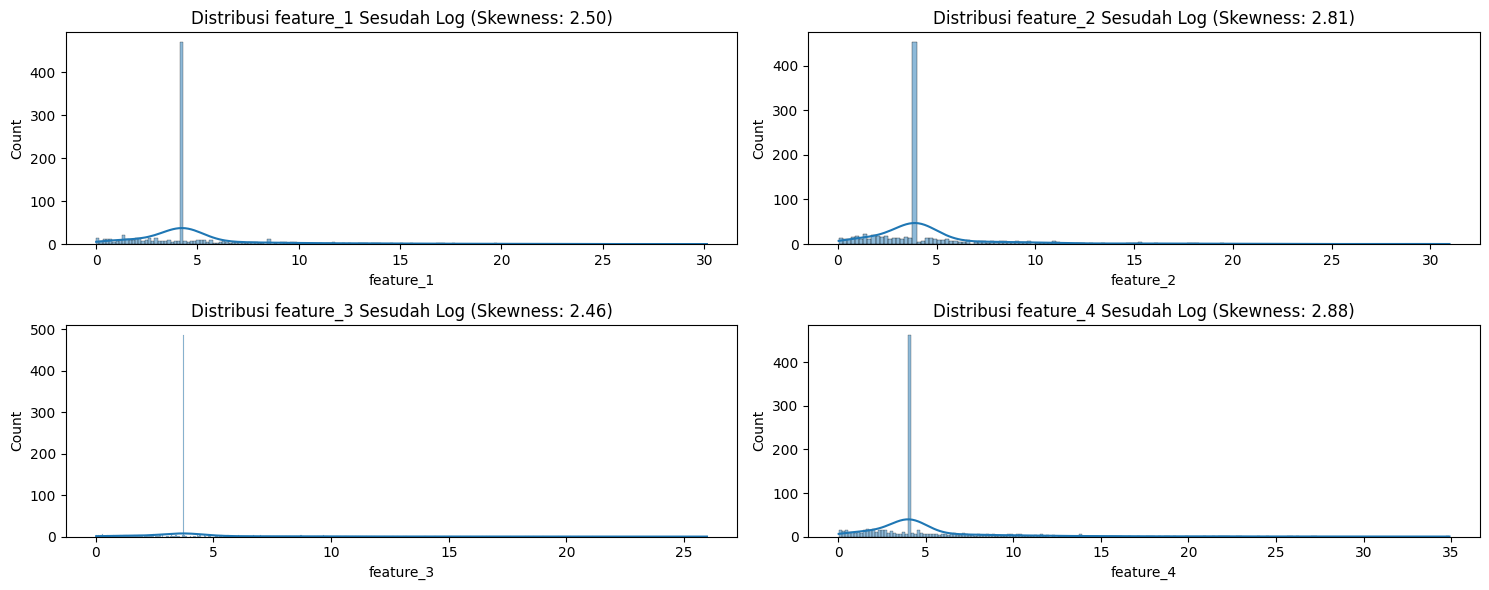

In [51]:
# 4.4 Transformasi Skewness (Sudah dilakukan di outlier via Log Transformasi)
# Sebelum dan sesudah log transformasi
compare_before_after(df, df_processed, 'skew', cols=['feature_1', 'feature_2', 'feature_3', 'feature_4'])
plt.figure(figsize=(15, 6))
for i, col in enumerate(['feature_1', 'feature_2', 'feature_3', 'feature_4']):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_processed[col], kde=True)
    plt.title(f'Distribusi {col} Sesudah Log (Skewness: {df_processed[col].skew():.2f})')
plt.tight_layout()
plt.show()


Sebelum Seleksi Fitur:
Jumlah fitur: 12


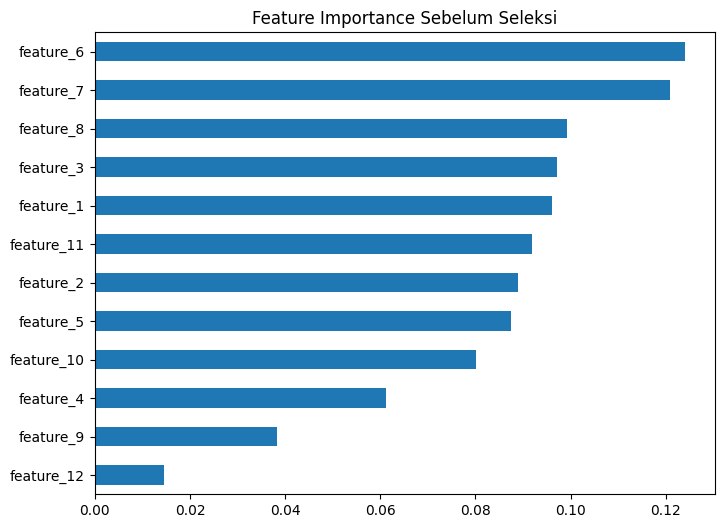


Sesudah Seleksi Fitur:
Fitur terpilih: Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10',
       'feature_11', 'feature_12'],
      dtype='object')
Jumlah fitur: 12


In [52]:
# 4.5 Seleksi Fitur
# Sebelum
print("\nSebelum Seleksi Fitur:")
print("Jumlah fitur:", len(df_processed.columns) - 1)
df_temp = df_processed.copy()
for col in ['feature_9', 'feature_10', 'feature_11', 'feature_12']:
    df_temp[col] = df_temp[col].astype('category').cat.codes
rf_select = RandomForestClassifier(n_estimators=50, random_state=42)
rf_select.fit(df_temp.drop('target', axis=1), df_temp['target'])
importances = pd.Series(rf_select.feature_importances_, index=df_temp.drop('target', axis=1).columns)
plt.figure(figsize=(8, 6))
importances.sort_values().plot(kind='barh')
plt.title("Feature Importance Sebelum Seleksi")
plt.show()

# Seleksi
selected_features = importances[importances > 0.01].index
df_processed = df_processed[list(selected_features) + ['target']]

# Sesudah
print("\nSesudah Seleksi Fitur:")
print("Fitur terpilih:", selected_features)
print("Jumlah fitur:", len(df_processed.columns) - 1)

In [53]:
# 4.6 Encoding Kategorikal (Label Encoding)
# Sebelum
print("\nSebelum Encoding Kategorikal:")
print(df_processed[['feature_9', 'feature_10', 'feature_11', 'feature_12']].head())

# Encoding
le_dict = {}
for col in df_processed.select_dtypes(include='object').columns:
    le_dict[col] = LabelEncoder()
    df_processed[col] = le_dict[col].fit_transform(df_processed[col])

# Sesudah
print("\nSesudah Encoding Kategorikal:")
print(df_processed[['feature_9', 'feature_10', 'feature_11', 'feature_12']].head())


Sebelum Encoding Kategorikal:
   feature_9 feature_10 feature_11  feature_12
0          1    cat10_2    cat11_0           0
1          0    cat10_9    cat11_8           0
2          1    cat10_1    cat11_5           1
3          1    cat10_0    cat11_5           1
4          1    cat10_1   cat11_21           0

Sesudah Encoding Kategorikal:
   feature_9  feature_10  feature_11  feature_12
0          1           7           0           0
1          0          14          28           0
2          1           1          25           1
3          1           0          25           1
4          1           1          14           0


In [54]:
# 4.7 Penanganan Ketidakseimbangan (SMOTE)
# Sebelum
X = df_processed.drop('target', axis=1)
y = df_processed['target']
print("\nSebelum SMOTE:")
print("Proporsi kelas:", pd.Series(y).value_counts(normalize=True))

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Sesudah
print("\nSesudah SMOTE:")
print("Shape setelah SMOTE:", X_resampled.shape)
print("Proporsi kelas:", pd.Series(y_resampled).value_counts(normalize=True))


Sebelum SMOTE:
Proporsi kelas: target
0    0.920202
1    0.079798
Name: proportion, dtype: float64

Sesudah SMOTE:
Shape setelah SMOTE: (1822, 12)
Proporsi kelas: target
0    0.5
1    0.5
Name: proportion, dtype: float64


In [30]:
pip install bayesian-optimization

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier

# Random Search
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['sqrt', 'log2', 0.3],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
random_search = RandomizedSearchCV(
    rf, param_distributions=param_grid, n_iter=5, cv=3,
    scoring='f1', n_jobs=-1, random_state=42
)
random_search.fit(X_resampled, y_resampled)
best_rf_random = random_search.best_estimator_
print("Random Search - Parameter terbaik:", random_search.best_params_)
print("Random Search - F1-score CV:", random_search.best_score_)

Random Search - Parameter terbaik: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'criterion': 'gini'}
Random Search - F1-score CV: 0.9267841768376178


In [59]:
from sklearn.model_selection import cross_val_score, train_test_split

# Bayesian Optimization
def rf_bayesian(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth) if max_depth > 0 else None
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    max_features = min(max_features, 1.0)
    rf = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
        max_features=max_features, criterion='gini',
        random_state=42, class_weight='balanced', n_jobs=-1
    )
    scores = cross_val_score(rf, X_resampled, y_resampled, cv=5, scoring='f1')
    return scores.mean()

pbounds = {
    'n_estimators': (100, 500),
    'max_depth': (10, 50),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'max_features': (0.1, 0.5)
}

optimizer = BayesianOptimization(f=rf_bayesian, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=20)
best_params_bayes = optimizer.max['params']
best_params_bayes['n_estimators'] = int(best_params_bayes['n_estimators'])
best_params_bayes['max_depth'] = int(best_params_bayes['max_depth']) if best_params_bayes['max_depth'] > 0 else None
best_params_bayes['min_samples_split'] = int(best_params_bayes['min_samples_split'])
best_params_bayes['min_samples_leaf'] = int(best_params_bayes['min_samples_leaf'])

best_rf_bayes = RandomForestClassifier(
    **best_params_bayes, criterion='gini', random_state=42, class_weight='balanced'
)
best_rf_bayes.fit(X_resampled, y_resampled)
print("Bayesian Optimization - Parameter terbaik:", best_params_bayes)
print("Bayesian Optimization - F1-score CV:", optimizer.max['target'])

# Pilih model terbaik
best_rf = best_rf_bayes if optimizer.max['target'] > random_search.best_score_ else best_rf_random

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.9246    | 24.98     | 0.4803    | 3.196     | 6.789     | 162.4     |
| 2         | 0.9376    | 16.24     | 0.1232    | 3.599     | 6.809     | 383.2     |
| 3         | 0.9228    | 10.82     | 0.488     | 3.497     | 3.699     | 172.7     |
| 4         | 0.9372    | 17.34     | 0.2217    | 2.574     | 5.456     | 216.5     |
| 5         | 0.9485    | 34.47     | 0.1558    | 1.876     | 4.931     | 282.4     |
| 6         | 0.9315    | 41.41     | 0.1799    | 2.543     | 6.739     | 118.6     |
| 7         | 0.9358    | 34.3      | 0.1682    | 1.195     | 9.591     | 486.3     |
| 8         | 0.9375    | 42.34     | 0.2218    | 1.293     | 7.474     | 276.1     |
| 9         | 0.9302    | 14.88     | 0.2981    | 1.103     | 9.275     | 203.5     |
| 10        | 0.933     | 36.5      | 0.2247    | 2.56

In [60]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

# Definisikan base models
base_models = [
    ('rf', best_rf),
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss')),
    ('lgbm', LGBMClassifier(random_state=42))
]

# Definisikan meta-model
meta_model = LogisticRegression(random_state=42)

# Inisialisasi stacking
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Latih model
stacking_clf.fit(X_resampled, y_resampled)
print("Stacking model selesai dilatih.")

Stacking model selesai dilatih.



Perbandingan Performa:
            Akurasi F1-score   ROC-AUC
Pelatihan  0.920749      0.0       1.0
Uji        0.918782      0.0  0.469268
Hold-Out   0.919192      0.0  0.523352

Gap (Pelatihan - Uji):
Akurasi     0.001968
F1-score         0.0
ROC-AUC     0.530732
dtype: object

Gap (Pelatihan - Hold-Out):
Akurasi     0.001557
F1-score         0.0
ROC-AUC     0.476648
dtype: object
OK: Tidak ada tanda overfitting signifikan (F1-score gap < 0.1)


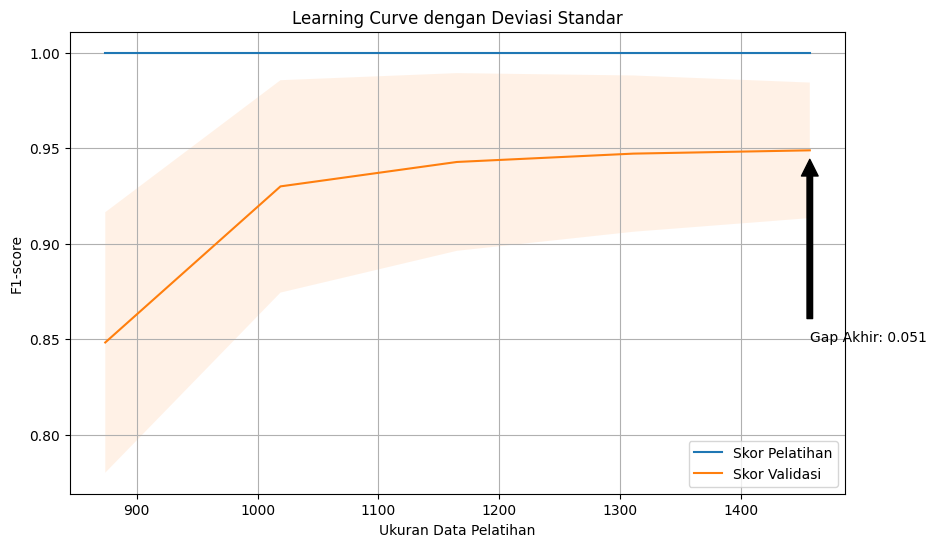

OK: Learning curve menunjukkan generalisasi baik (gap < 0.1)

F1-score Pelatihan: 0.000
F1-score CV: 0.000 ± 0.000
Gap (Pelatihan - CV): 0.000
OK: Performa pelatihan konsisten dengan CV


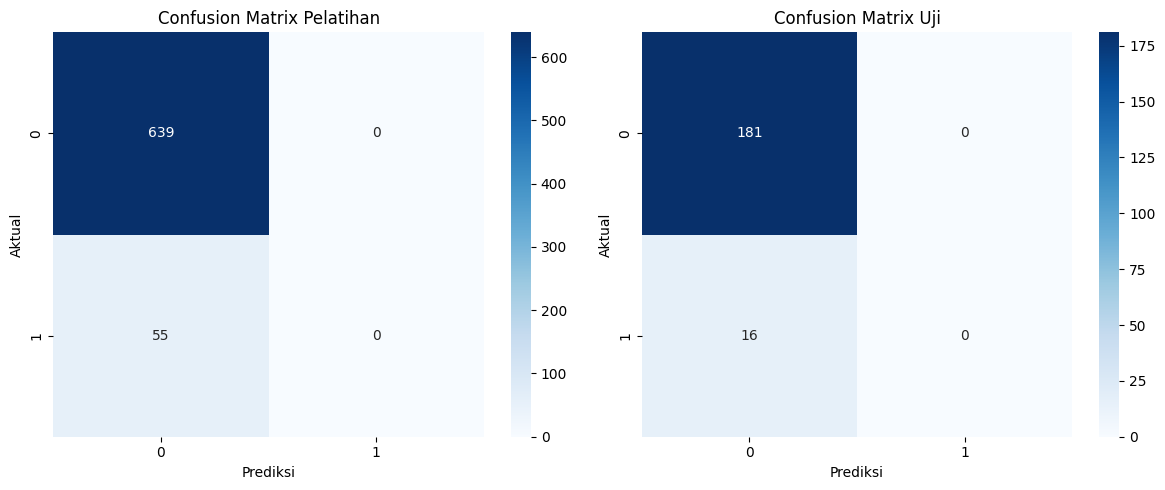


Recall per Kelas:
Pelatihan - Kelas 0: 1.000, Kelas 1: 0.000
Uji - Kelas 0: 1.000, Kelas 1: 0.000
OK: Recall kelas minoritas stabil


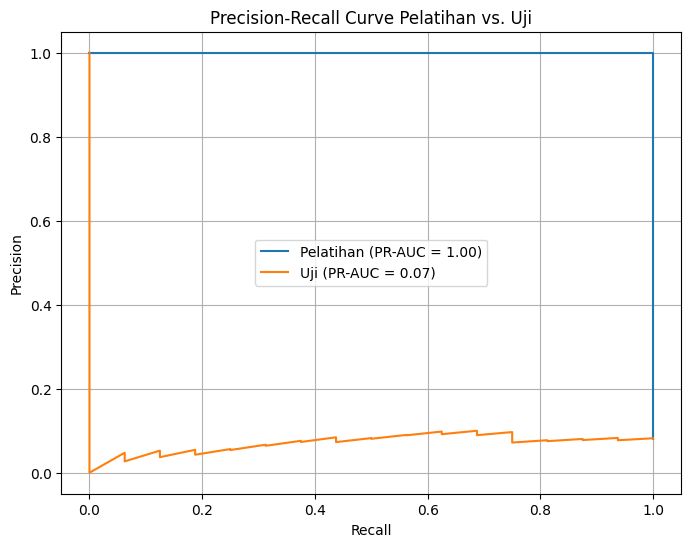

PERINGATAN: Penurunan PR-AUC menunjukkan overfitting


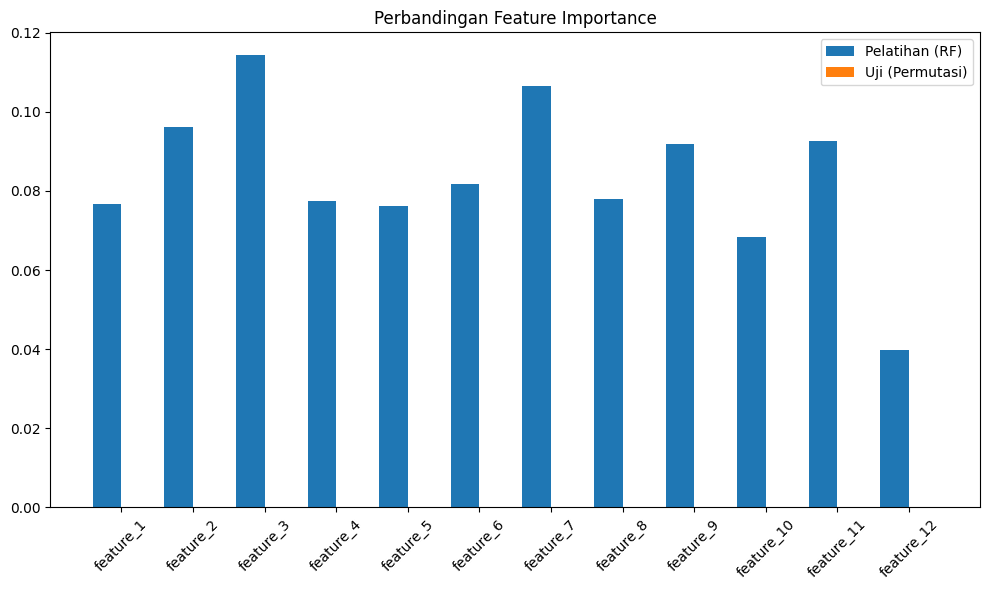

OK: Feature importance konsisten

Classification Report (Uji):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       181
           1       0.00      0.00      0.00        16

    accuracy                           0.92       197
   macro avg       0.46      0.50      0.48       197
weighted avg       0.84      0.92      0.88       197


Kesimpulan Overfitting:
Model menunjukkan TANDA RINGAN overfitting. Pertimbangkan regularisasi ringan atau validasi lebih lanjut.


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split
from sklearn.inspection import permutation_importance
import shap

# Pisahkan data uji dan hold-out set
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train_val, y_train_val, test_size=0.22, random_state=42, stratify=y_train_val)

# Prediksi pada pelatihan, uji, dan hold-out
stacking_clf.fit(X_train, y_train)
y_train_pred = stacking_clf.predict(X_train)
y_train_proba = stacking_clf.predict_proba(X_train)[:, 1]
y_test_pred = stacking_clf.predict(X_test)
y_test_proba = stacking_clf.predict_proba(X_test)[:, 1]
y_holdout_pred = stacking_clf.predict(X_holdout)
y_holdout_proba = stacking_clf.predict_proba(X_holdout)[:, 1]

# 1. Perbandingan Performa Pelatihan vs. Uji vs. Hold-Out
metrics = {
    'Akurasi': accuracy_score,
    'F1-score': f1_score,
    'ROC-AUC': roc_auc_score
}

results = pd.DataFrame(index=['Pelatihan', 'Uji', 'Hold-Out'], columns=metrics.keys())
results.loc['Pelatihan'] = [metrics[m](y_train, y_train_pred if m != 'ROC-AUC' else y_train_proba) for m in metrics]
results.loc['Uji'] = [metrics[m](y_test, y_test_pred if m != 'ROC-AUC' else y_test_proba) for m in metrics]
results.loc['Hold-Out'] = [metrics[m](y_holdout, y_holdout_pred if m != 'ROC-AUC' else y_holdout_proba) for m in metrics]

print("\nPerbandingan Performa:")
print(results)
print("\nGap (Pelatihan - Uji):")
print(results.loc['Pelatihan'] - results.loc['Uji'])
print("\nGap (Pelatihan - Hold-Out):")
print(results.loc['Pelatihan'] - results.loc['Hold-Out'])

# Interpretasi otomatis
f1_gap_test = results.loc['Pelatihan', 'F1-score'] - results.loc['Uji', 'F1-score']
if f1_gap_test > 0.15:
    print("PERINGATAN: Potensi overfitting kuat (F1-score gap > 0.15)")
elif f1_gap_test > 0.1:
    print("CATATAN: Potensi overfitting ringan (F1-score gap > 0.1)")
else:
    print("OK: Tidak ada tanda overfitting signifikan (F1-score gap < 0.1)")

# 2. Learning Curve dengan Deviasi Standar
train_sizes, train_scores, val_scores = learning_curve(
    stacking_clf, X_resampled, y_resampled, cv=5, scoring='f1',
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Skor Pelatihan')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, label='Skor Validasi')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.xlabel("Ukuran Data Pelatihan")
plt.ylabel("F1-score")
plt.title("Learning Curve dengan Deviasi Standar")
plt.legend()
plt.grid(True)
plt.annotate(f"Gap Akhir: {train_mean[-1] - val_mean[-1]:.3f}",
             xy=(train_sizes[-1], val_mean[-1]), xytext=(train_sizes[-1], val_mean[-1] - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

# Interpretasi learning curve
if train_mean[-1] - val_mean[-1] > 0.1:
    print("PERINGATAN: Learning curve menunjukkan overfitting (gap > 0.1)")
else:
    print("OK: Learning curve menunjukkan generalisasi baik (gap < 0.1)")

# 3. Cross-Validation vs. Pelatihan
f1_train = f1_score(y_train, y_train_pred)
cv_scores = cross_val_score(stacking_clf, X_train, y_train, cv=5, scoring='f1')
f1_cv = cv_scores.mean()

print(f"\nF1-score Pelatihan: {f1_train:.3f}")
print(f"F1-score CV: {f1_cv:.3f} ± {cv_scores.std():.3f}")
print(f"Gap (Pelatihan - CV): {f1_train - f1_cv:.3f}")

# Interpretasi CV
if f1_train - f1_cv > 0.1:
    print("PERINGATAN: Gap besar antara pelatihan dan CV menunjukkan overfitting")
else:
    print("OK: Performa pelatihan konsisten dengan CV")

# 4. Confusion Matrix Pelatihan vs. Uji
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix Pelatihan")
axes[0].set_xlabel("Prediksi")
axes[0].set_ylabel("Aktual")

cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("Confusion Matrix Uji")
axes[1].set_xlabel("Prediksi")
axes[1].set_ylabel("Aktual")
plt.tight_layout()
plt.show()

# Hitung recall per kelas
from sklearn.metrics import recall_score
recall_train = recall_score(y_train, y_train_pred, average=None)
recall_test = recall_score(y_test, y_test_pred, average=None)
print("\nRecall per Kelas:")
print(f"Pelatihan - Kelas 0: {recall_train[0]:.3f}, Kelas 1: {recall_train[1]:.3f}")
print(f"Uji - Kelas 0: {recall_test[0]:.3f}, Kelas 1: {recall_test[1]:.3f}")

# Interpretasi recall
if recall_test[1] < recall_train[1] - 0.2:
    print("PERINGATAN: Penurunan recall kelas minoritas menunjukkan overfitting")
else:
    print("OK: Recall kelas minoritas stabil")

# 5. Precision-Recall Curve Pelatihan vs. Uji
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
pr_auc_train = auc(recall_train, precision_train)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc_test = auc(recall_test, precision_test)

plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, label=f'Pelatihan (PR-AUC = {pr_auc_train:.2f})')
plt.plot(recall_test, precision_test, label=f'Uji (PR-AUC = {pr_auc_test:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Pelatihan vs. Uji")
plt.legend()
plt.grid(True)
plt.show()

# Interpretasi PR-AUC
if pr_auc_train - pr_auc_test > 0.15:
    print("PERINGATAN: Penurunan PR-AUC menunjukkan overfitting")
else:
    print("OK: PR-AUC stabil")

# 6. Feature Importance Stabilitas
importances_train = pd.Series(best_rf.feature_importances_, index=X_train.columns)
perm_importance = permutation_importance(stacking_clf, X_test, y_test, n_repeats=10, random_state=42)
importances_test = pd.Series(perm_importance.importances_mean, index=X_test.columns)

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(importances_train)) - 0.2, importances_train, 0.4, label='Pelatihan (RF)')
plt.bar(np.arange(len(importances_test)) + 0.2, importances_test, 0.4, label='Uji (Permutasi)')
plt.xticks(np.arange(len(importances_train)), importances_train.index, rotation=45)
plt.title("Perbandingan Feature Importance")
plt.legend()
plt.tight_layout()
plt.show()

# Interpretasi feature importance
if (importances_train.sort_index() - importances_test.sort_index()).abs().mean() > 0.1:
    print("PERINGATAN: Ketidakkonsistenan feature importance menunjukkan overfitting")
else:
    print("OK: Feature importance konsisten")

# 7. Classification Report
print("\nClassification Report (Uji):")
print(classification_report(y_test, y_test_pred))

# 9. Kesimpulan Overfitting
print("\nKesimpulan Overfitting:")
overfitting_indicators = [
    f1_gap_test > 0.15,
    train_mean[-1] - val_mean[-1] > 0.1,
    f1_train - f1_cv > 0.1,
    recall_test[1] < recall_train[1] - 0.2,
    pr_auc_train - pr_auc_test > 0.15,
    (importances_train.sort_index() - importances_test.sort_index()).abs().mean() > 0.1
]
if sum(overfitting_indicators) >= 3:
    print("Model kemungkinan besar OVERFIT. Rekomendasi: Tambah regularisasi (batasi max_depth, tingkatkan min_samples_leaf), kurangi fitur, atau tambah data.")
elif sum(overfitting_indicators) >= 1:
    print("Model menunjukkan TANDA RINGAN overfitting. Pertimbangkan regularisasi ringan atau validasi lebih lanjut.")
else:
    print("Model menggeneralisasi dengan BAIK. Tidak ada tanda overfitting signifikan.")